In [4]:
#!pip uninstall -y tensorflow tensorflow-text
#!pip install -q tensorflow==2.19.0 tensorflow-text==2.19.0
#!pip install -q transformers==4.44.2 scikit-learn pandas numpy==1.26.4 ml-dtypes==0.5.1

'''
Hugging Face has deprecated TensorFlow (TF) and JAX model classes in the latest transformers versions (≥ 4.45).
They are migrating fully to PyTorch.
So when you try to load a TF model (TFBertForSequenceClassification), it tries to read the .safetensors PyTorch checkpoint,
but can’t — resulting in this TypeError.
'''
#!pip install --upgrade transformers datasets torch scikit-learn -q
#!pip install --upgrade transformers

'\nHugging Face has deprecated TensorFlow (TF) and JAX model classes in the latest transformers versions (≥ 4.45).\nThey are migrating fully to PyTorch.\nSo when you try to load a TF model (TFBertForSequenceClassification), it tries to read the .safetensors PyTorch checkpoint, \nbut can’t — resulting in this TypeError.\n'

In [5]:
#!pip uninstall -y transformers tokenizers huggingface_hub accelerate wandb
#!pip uninstall -y tensorflow tensorflow-text tensorflow-datasets keras


In [6]:
# Clean up conflicting or unused packages
#!pip uninstall -y timm peft

# Install everything required for BERT Trainer
#!pip install -U torch torchvision torchaudio -q
#!pip install -U transformers datasets scikit-learn accelerate huggingface_hub -q


In [7]:
import torch, transformers, datasets, accelerate
print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("Accelerate:", accelerate.__version__)


Torch: 2.9.1+cu128
Transformers: 4.57.3
Datasets: 4.4.2
Accelerate: 1.12.0


FINAL: Fine-tune BERT using Hugging Face Trainer (PyTorch backend)

Works with: torch 2.9.1, transformers 4.57.3, datasets 4.4.2, accelerate 1.12.0


# Import Required Libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')

# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

# required to visualize the most common words in reviews
from wordcloud import WordCloud

## Sentiment Analysis (VADER)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sent_tokenize
#Download required NLTK data (only need to run once)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('owm-1.4')
nltk.download('vader_lexicon')

# Deep Learning
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer
from transformers.training_args import TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from datasets import Dataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading owm-1.4: Package 'owm-1.4' not found in
[nltk_data]     index
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Mount Google Drive for Data Access

In [11]:
from google.colab import drive
drive.mount('/content/drive')

#Files “Shared with me” are not automatically under MyDrive, so add a shortcut to that file in mydrive and access it, other-wise not required.
folder_path = "/content/drive/MyDrive/E_Commerce_project_text_classification"
import os
os.listdir(folder_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Dataset.zip',
 'NLP_Product_Reviews_Dataset.csv',
 'Models_results',
 'Procfile',
 '.env',
 'E-Commerce_Text_Classification.ipynb',
 'user_product_matrix.zip',
 '.git',
 'requirements.txt',
 'user_product_matrix.csv',
 'Recommendation_system.ipynb',
 'app-original.ipynb',
 '.gitignore',
 'app.ipynb',
 'app.py',
 'app',
 'required_text_files.ipynb',
 'BERT For E-Commerce Text Classification.ipynb']

# Step 1: Load the Data

In [12]:
df = pd.read_csv('/content/drive/MyDrive/E_Commerce_project_text_classification/NLP_Product_Reviews_Dataset.csv')
df.head()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.02537E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,67981934427


# Step 2: Describe the Data

In [13]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71044 entries, 0 to 71043
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    71044 non-null  object 
 1   brand                 71044 non-null  object 
 2   categories            71044 non-null  object 
 3   dateAdded             71044 non-null  object 
 4   dateUpdated           71044 non-null  object 
 5   ean                   39065 non-null  object 
 6   keys                  71044 non-null  object 
 7   manufacturer          70903 non-null  object 
 8   manufacturerNumber    70841 non-null  object 
 9   name                  71044 non-null  object 
 10  reviews.date          70977 non-null  object 
 11  reviews.dateAdded     71044 non-null  object 
 12  reviews.dateSeen      71044 non-null  object 
 13  reviews.didPurchase   32158 non-null  object 
 14  reviews.doRecommend   60429 non-null  object 
 15  reviews.id         

(71044, 25)

Here the data set contains 71045 (starts from 0) rows and 25 columns

In [14]:
df.columns

Index(['id', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'ean', 'keys',
       'manufacturer', 'manufacturerNumber', 'name', 'reviews.date',
       'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase',
       'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'upc'],
      dtype='object')

In [15]:
df.describe(include ='all') # include ='all' means 'text + numeric' columns only describe wii give you 'numeric' columns

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
count,71044,71044,71044,71044,71044,39065,71044,70903,70841,71044,...,3.215800e+04,32508.000000,71044.000000,71044,71008,70567,5410,449,70942,71042
unique,600,392,581,598,354,473,600,463,583,600,...,NaN,NaN,NaN,22508,64913,42681,2282,52,58087,562
top,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",2015-09-11T18:17:13Z,2018-02-05T10:22:44Z,44600015996,"clorox/12992356,044600015996,cloroxdisinfectin...",Clorox,12992356,Clorox Disinfecting Wipes Value Pack Scented 1...,...,NaN,NaN,NaN,https://redsky.target.com/groot-domain-api/v1/...,Good,Great movie,Chicago,CA,An anonymous customer,44600015996
freq,8606,10700,8606,8606,13753,8606,8606,8607,8606,8606,...,NaN,NaN,NaN,196,26,1367,68,40,421,8606
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.944753e+07,0.410422,4.385747,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.842696e+07,3.574442,1.067659,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.187400e+04,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.355342e+07,0.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.124763e+07,0.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.112628e+08,0.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Checking missing values

In [16]:
df.isnull().sum()

,0
id,0
brand,0
categories,0
dateAdded,0
dateUpdated,0
ean,31979
keys,0
manufacturer,141
manufacturerNumber,203
name,0


# Step 3 : DATA CLEANING

* Remove Duplicate rows

In [17]:
df.drop_duplicates()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.02537E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,67981934427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71039,AVzRGDlw-jtxr-f3yfFH,Opti-Free,"Personal Care,Eye & Ear Care,Eye Care,Contact ...",2017-06-22T18:37:24Z,2018-02-05T11:28:36Z,"3,006,503,610,570,300,000,000,000,000,000,000,...",optifreepuremoistdisinfectingsolution10floz/b0...,Opti-Free,11014438,Opti-Free Puremoist Disinfecting Solution 10fl Oz,...,6855681.0,6.0,5,https://www.walmart.com/reviews/product/10294231,I'm dealing with dry eyes and very sensitive t...,Solves the problem,NaN,NaN,Seniorgal,"300650361040,631113253665,300650193108,3006503..."
71040,AVzRGDlw-jtxr-f3yfFH,Opti-Free,"Personal Care,Eye & Ear Care,Eye Care,Contact ...",2017-06-22T18:37:24Z,2018-02-05T11:28:36Z,"3,006,503,610,570,300,000,000,000,000,000,000,...",optifreepuremoistdisinfectingsolution10floz/b0...,Opti-Free,11014438,Opti-Free Puremoist Disinfecting Solution 10fl Oz,...,71102868.0,1.0,5,https://www.walmart.com/reviews/product/10294231,Great stuff! Helps keep my contacts moist all ...,Great stuff!,NaN,NaN,Nammaw,"300650361040,631113253665,300650193108,3006503..."
71041,AVzRGDlw-jtxr-f3yfFH,Opti-Free,"Personal Care,Eye & Ear Care,Eye Care,Contact ...",2017-06-22T18:37:24Z,2018-02-05T11:28:36Z,"3,006,503,610,570,300,000,000,000,000,000,000,...",optifreepuremoistdisinfectingsolution10floz/b0...,Opti-Free,11014438,Opti-Free Puremoist Disinfecting Solution 10fl Oz,...,58039428.0,0.0,5,https://www.walmart.com/reviews/product/10294231,Right price,My review,NaN,NaN,LDBoston,"300650361040,631113253665,300650193108,3006503..."
71042,AVzvTLfivKc47QAVfPme,Bebe Au Lait,"Baby,Nursing & Feeding,Breastfeeding,Nursing C...",2017-06-28T15:23:21Z,2018-02-05T10:19:41Z,8.78982E+11,"878982005883,bebeaulait/50032623,08789820

There are no duplicate rows

* Handiling missing values

In [18]:
df= df.dropna(subset = ['reviews.text'])  # drop rows with missing text in 'review.text' column
df.fillna('unknown', inplace=True) #Replace other missing fields

Clean your text (lowercase, remove punctuation, stopwords, etc.)

In [19]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def core_clean(text, stopword_set):
    """Reusable text cleaning function"""
    if not isinstance(text, str):
        return []

    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stopword_set and len(w) > 2]
    return tokens

Basic Clean

Uses only standard stopwords.

In [20]:
def basic_clean(text):
    return core_clean(text, stop_words)

Build Frequency-Based Stopwords

Automatically detect and extend stopword list.

Detect Top N Frequent Words

In [21]:
# Apply basic cleaning first to detect frequent noisy words
df['tokens'] = df['reviews.text'].apply(basic_clean)

# Flatten all tokens and count frequency
all_tokens = [word for tokens in df['tokens'] for word in tokens]
freq_dist = Counter(all_tokens)

# Take top N frequent words (e.g., 20)
N = 20
common_words = set([word for word, freq in freq_dist.most_common(N)])
extended_stopwords = stop_words.union(common_words)

Remove the Top N Frequent Words

Remove those that dominate the text (often boilerplate or noise).

Smart Clean

Reuses the same core cleaning logic but with extended stopwords.

In [22]:
def smart_clean(text):
    tokens = core_clean(text, extended_stopwords)
    return ' '.join(tokens)

In [23]:
# Applying cleaning function for dataset
df['cleaned_reviews'] = df['reviews.text'].apply(smart_clean)

In [24]:
Counter(' '.join(df['cleaned_reviews']).split()).most_common(20)

[('used', 6676),
 ('wipe', 6561),
 ('feel', 6364),
 ('get', 6337),
 ('well', 6329),
 ('make', 6186),
 ('work', 6172),
 ('day', 6045),
 ('easy', 5770),
 ('first', 5233),
 ('much', 5209),
 ('year', 5117),
 ('tide', 4924),
 ('kid', 4870),
 ('also', 4703),
 ('look', 4598),
 ('product', 4567),
 ('dont', 4562),
 ('best', 4554),
 ('clorox', 4450)]

In [25]:
df[['reviews.text','cleaned_reviews']].head(10)

,reviews.text,cleaned_reviews
0,i love this album. it's very good. more to the...,album hip hop side current pop sound hype list...
1,Good flavor. This review was collected as part...,flavor
2,Good flavor.,flavor
3,I read through the reviews on here before look...,read review looking buying couple lubricant ul...
4,My husband bought this gel for us. The gel cau...,husband bought gel gel caused irritation felt ...
5,My boyfriend and I bought this to spice things...,boyfriend bought spice thing bedroom highly di...
6,Bought this earlier today and was excited to c...,bought earlier today excited check based descr...
7,I bought this product for my husband and I to ...,bought husband try impressed tingling warming ...
8,My husband and I bought this for some extra fu...,husband bought extra fun werevboth extremely d...
9,Got as a surprise for my husband there is noth...,got surprise husband nothing special lube save...


In [26]:
# Checking shape and columns of the dataset
print('Shape:',df.shape)
print('Cloumns:', df.columns)

Shape: (71008, 27)
Cloumns: Index(['id', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'ean', 'keys',
       'manufacturer', 'manufacturerNumber', 'name', 'reviews.date',
       'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase',
       'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'upc',
       'tokens', 'cleaned_reviews'],
      dtype='object')


In [27]:
# Basic Statistics
#df.describe(include='all')

In [28]:
#Check Missing values
df.isnull()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc,tokens,cleaned_reviews
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71039,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
71040,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
71041,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
71042,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [29]:
df.isna().sum()

,0
id,0
brand,0
categories,0
dateAdded,0
dateUpdated,0
ean,0
keys,0
manufacturer,0
manufacturerNumber,0
name,0


Data is cleaned!

# Step 4:  Exploratory Data Analysis

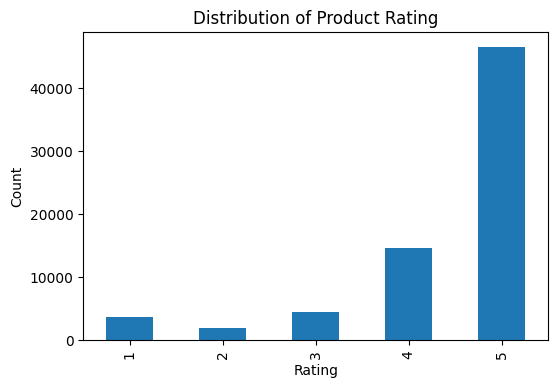

In [30]:
plt.figure(figsize=(6,4))
df['reviews.rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Product Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

By reviewing the bar chart product rating is maximum on 5 comparetive to other ratings and count is nearly above 45000 ratings are on 5.

In [31]:
# Avarage Rating by Product/Manufacturer
df.groupby('manufacturer')['reviews.rating'].mean().sort_values(ascending=False).head(10)

,reviews.rating
manufacturer,
Timekeeper,5.0
Universal Music Group / Cash Money,5.0
Unfi,5.0
York Wallcoverings,5.0
"ACCO BRANDS, INC.",5.0
ACCO,5.0
Tillamook,5.0
Tramontina USA Inc.,5.0
Cadbury Schweppes Americas Beverages,5.0


These are top 10 manufacturers with high ratings

# Step 5:  Word Cloud (Based on Product Rating)
You can visualize the most common words in reviews for Positive vs Negative ratings.

<function matplotlib.pyplot.show(close=None, block=None)>

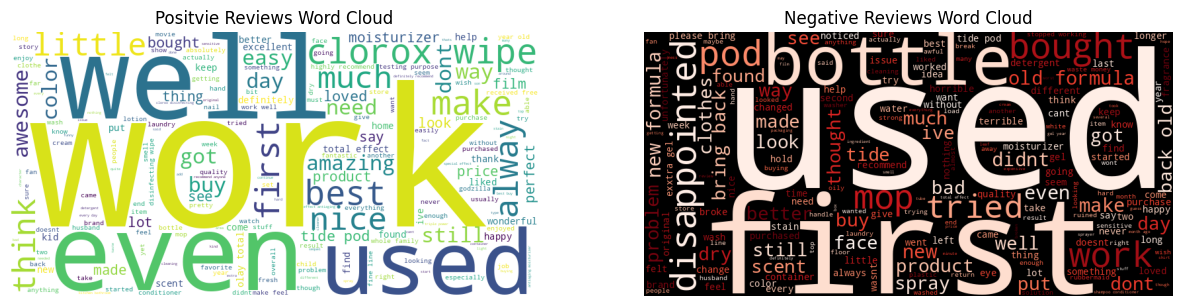

In [32]:
# Positive and Negative words split (change the threshold as needed)
positive_reviews = df[df['reviews.rating']>=4]['cleaned_reviews'].dropna().str.cat(sep = ' ')
negative_reviews = df[df['reviews.rating']<=2]['cleaned_reviews'].dropna().str.cat(sep = ' ')

#Generate Cloud Words
pos_wc = WordCloud(width=800, height = 400, background_color= 'white').generate(positive_reviews)
neg_wc = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_reviews)

# plot
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(pos_wc)
plt.title('Positvie Reviews Word Cloud')
plt.axis('off')


plt.subplot(1,2,2)
plt.imshow(neg_wc)
plt.title('Negative Reviews Word Cloud')
plt.axis('off')
plt.show

## This gives a clear visual of which words dominate in high vs. low Ratings

# Step 6: Sentiment Analysis

we can use TexrBolb or VADER to measure the sentiment-score(polarity) of each review.

# 1. Opinion Word Polarity Identification
VADER(Recommended for short reviews)

In [33]:
sid = SentimentIntensityAnalyzer()

# get polarity(sentiment score) of each review
df['sentiment_score']= df['cleaned_reviews'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

# defining the function to categorise Positive, negative and neutral
def get_sentiment(score):
  if score >= 0.005:
    return 'Positive'
  elif score <= -0.005:
    return 'Negative'
  else:
    return 'Neutral'

df['sentiment'] = df['sentiment_score'].apply(get_sentiment)


In [34]:
df['sentiment'].head()

,sentiment
0,Negative
1,Neutral
2,Neutral
3,Negative
4,Negative


## 2. Opinion Sentence Polarity Identification

If you want per sentence Polarity.


use this other wise no need of this.

In [35]:
def sentence_polarity(text):
  sentence = sent_tokenize(str(text))
  scores = [sid.polarity_scores(s)['compound'] for s in sentence]
  return sum(scores)/len(scores) if scores else 0

df['sentence_sentiment_score']= df['cleaned_reviews'].apply(sentence_polarity)

In [36]:
df['sentence_sentiment_score'].head()

,sentence_sentiment_score
0,-0.3400
1,0.0000
2,0.0000
3,-0.8335
4,-0.6608


# STEP 7: Modelling using DL Technique i.e, BERT

### Preparing Data for DL Model(BERT Model)

*   TF-IDF converts text directly into numerical feature vectors, so your ML models (Logistic Regression, Random Forest, etc.) can use X_train and X_test as-is.
*   That’s why we used train_test_split after vectorization.



##### In Deep Learning Models


*   Deep learning models (like LSTM, CNN, GRU) cannot use TF-IDF vectors directly —
they need sequential numeric representations of words (like tokens or embeddings).
*   So, we must reuse the same text split (train/test) but reprocess the text differently before feeding it to DL models.

*   So we are reusing the same train/test division from ML,
but just changing how the text is represented for deep learning models.


#### Switching fully to PyTorch + Hugging Face Trainer is the cleanest approach — won’t run into TensorFlow/Keras issues like KerasTensor or .compile() errors.

### 1.Prepare data

In [37]:
# Install required libraries (if not already)
#!pip install transformers datasets torch scikit-learn
#!pip install --upgrade transformers datasets

In [38]:
TEXT_COLUMN = 'cleaned_reviews'
LABEL_COLUMN = 'sentiment'

# Encode labels
le = LabelEncoder()
df['labels'] = le.fit_transform(df[LABEL_COLUMN])  # Must be 'labels'

# Train/validation split with stratification
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df[TEXT_COLUMN].tolist(),
    df['labels'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['labels']
)

### 2. Tokenize texts
tokenize the data in a way compatible with Hugging Face Dataset

In [39]:
# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict({
    'text': train_texts,
    'labels': train_labels
})
val_dataset = Dataset.from_dict({
    'text': val_texts,
    'labels': val_labels
})

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

# Apply tokenization
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

# Keep only columns needed by Trainer
train_dataset = train_dataset.remove_columns(['text'])
val_dataset = val_dataset.remove_columns(['text'])

# Set format for PyTorch
train_dataset.set_format(type='torch')
val_dataset.set_format(type='torch')

Map:   0%|          | 0/56806 [00:00<?, ? examples/s]

Map:   0%|          | 0/14202 [00:00<?, ? examples/s]

### 3.Load Model

In [40]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(le.classes_)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4.Define training arguments

In [41]:
print(transformers.__version__) #If it’s older than 4.5.0, evaluation_strategy and some other arguments are not available.

4.57.3


In [42]:
import transformers, sys
print("Transformers version:", transformers.__version__)
print("Transformers path:", transformers.__file__)
print("Python version:", sys.version)
from transformers import TrainingArguments
print(TrainingArguments.__module__)


Transformers version: 4.57.3
Transformers path: /usr/local/lib/python3.12/dist-packages/transformers/__init__.py
Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
transformers.training_args


In [43]:
from transformers import TrainingArguments
import inspect
print("Module:", TrainingArguments.__module__)
print("File:", inspect.getfile(TrainingArguments))
help(TrainingArguments.__init__)


Module: transformers.training_args
File: /usr/local/lib/python3.12/dist-packages/transformers/training_args.py
Help on function __init__ in module transformers.training_args:

__init__(self, output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: float = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_sched

Error happening for this reason.  
Older versions (≤ 4.45) → evaluation_strategy.  
Newer versions (≥ 4.56 / 4.57) → eval_strategy

In [44]:
# from transformers.training_args import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    logging_steps=50,
    learning_rate=2e-5,
    save_strategy='epoch',
    eval_strategy='epoch',           # 👈 use this instead of evaluation_strategy
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to=[]
)

print("✅ TrainingArguments initialized successfully")

✅ TrainingArguments initialized successfully


### 5. Metrics

In [45]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

### 6. Trainer

In [46]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

### 7. Train the model


In [47]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.126000,0.134568,0.961555,0.960840,0.960739,0.961555
2,0.071800,0.116286,0.971342,0.971398,0.971465,0.971342


TrainOutput(global_step=7102, training_loss=0.1499643955422737, metrics={'train_runtime': 2562.2959, 'train_samples_per_second': 44.34, 'train_steps_per_second': 2.772, 'total_flos': 7473210403728384.0, 'train_loss': 0.1499643955422737, 'epoch': 2.0})

### 8. Evaluate the model

In [48]:
results = trainer.evaluate()
print("Evaluation results:", results)

Evaluation results: {'eval_loss': 0.11628566682338715, 'eval_accuracy': 0.971342064497958, 'eval_f1': 0.9713981031934737, 'eval_precision': 0.971464663190634, 'eval_recall': 0.971342064497958, 'eval_runtime': 98.7474, 'eval_samples_per_second': 143.821, 'eval_steps_per_second': 8.993, 'epoch': 2.0}


### 9. Save model and tokenizer

In [49]:
model.save_pretrained("/content/drive/MyDrive/E_Commerce_project_text_classification/Models_results/DL_models/bert_finetuned")
tokenizer.save_pretrained("/content/drive/MyDrive/E_Commerce_project_text_classification/Models_results/DL_models/bert_finetuned")

('/content/drive/MyDrive/E_Commerce_project_text_classification/Models_results/DL_models/bert_finetuned/tokenizer_config.json',
 '/content/drive/MyDrive/E_Commerce_project_text_classification/Models_results/DL_models/bert_finetuned/special_tokens_map.json',
 '/content/drive/MyDrive/E_Commerce_project_text_classification/Models_results/DL_models/bert_finetuned/vocab.txt',
 '/content/drive/MyDrive/E_Commerce_project_text_classification/Models_results/DL_models/bert_finetuned/added_tokens.json')

### 10. load and use the saved model later
You can reload the same model anytime:

In [51]:
#from transformers import BertTokenizer, BertForSequenceClassification

model_path = "/content/drive/MyDrive/E_Commerce_project_text_classification/Models_results/DL_models/bert_finetuned"

tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

### Predict sentiment for each review

In [54]:
!pip install tqdm

In [55]:
import torch
import numpy as np
from tqdm import tqdm  # progress bar

# Ensure model in evaluation mode
model.eval()

# Tokenize all texts together (batched)
encodings = tokenizer(
    texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt"
)

# Move model and inputs to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
encodings = {k: v.to(device) for k, v in encodings.items()}

# Run inference in batches
batch_size = 32
pred_labels = []

for i in tqdm(range(0, len(texts), batch_size)):
    batch_input = {k: v[i:i+batch_size] for k, v in encodings.items()}
    with torch.no_grad():
        outputs = model(**batch_input)
        preds = outputs.logits.argmax(dim=1).cpu().numpy()
        pred_labels.extend(preds)

# Convert numeric predictions to class names
df["predicted_label"] = le.inverse_transform(np.array(pred_labels))

# Display few predictions
print(df[["cleaned_reviews", "predicted_label"]].head())


100%|██████████| 2219/2219 [07:19<00:00,  5.05it/s]


                                     cleaned_reviews predicted_label
0  album hip hop side current pop sound hype list...        Negative
1                                             flavor         Neutral
2                                             flavor         Neutral
3  read review looking buying couple lubricant ul...        Negative
4  husband bought gel gel caused irritation felt ...        Negative


### Save predictions back to CSV

In [56]:
output_path = "/content/drive/MyDrive/E_Commerce_project_text_classification/Models_results/DL_models/bert_predictions.csv"
df.to_csv(output_path, index=False)
print(f"✅ Predictions saved to: {output_path}")

✅ Predictions saved to: /content/drive/MyDrive/E_Commerce_project_text_classification/Models_results/DL_models/bert_predictions.csv


In [41]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                        num_labels=len(le.classes_),
                                                        from_pt=True   # <-- important!
                                                        )

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=2)


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x79faec8ac860>

### 5. Evaluate model

In [ ]:
preds = model.predict(test_dataset).logits
y_pred = np.argmax(preds, axis=1)
y_true = np.array(test_labels)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=le.classes_))


888/888 [==============================] - 131s 144ms/step
Accuracy: 0.9741585692156034

Classification Report:
               precision    recall  f1-score   support

    Negative       0.83      0.85      0.84       884
     Neutral       0.86      0.93      0.90       539
    Positive       0.99      0.98      0.99     12779

    accuracy                           0.97     14202
   macro avg       0.89      0.92      0.91     14202
weighted avg       0.97      0.97      0.97     14202



# Step 8: Save the Model
### 1.Save the fine-tuned BERT model
The easiest and most standard way for Transformers is

In [ ]:
model.save_pretrained("/content/drive/MyDrive/E_Commerce_project_text_classification/Models_results/DL_models/bert_finetuned_model_hf")
tokenizer.save_pretrained("/content/drive/MyDrive/E_Commerce_project_text_classification/Models_results/DL_models/bert_finetuned_model_hf")
print(" Model and tokenizer is saved to Google Drive folder 'E_Commerce_project_text_classification/Models_results/DL_models/'")

### 2. Save the training history

In [ ]:
pd.DataFrame(history.history).to_csv("/content/drive/MyDrive/E_Commerce_project_text_classification/bert_history.csv", index=False)
print(" Model history is saved as csv file in Google Drive folder 'E_Commerce_project_text_classification'")

### 3. Then zip and download it:

In [ ]:
!zip -r "/content/drive/MyDrive/E_Commerce_project_text_classification/Models_results/DL_models/bert_finetuned_model_hf.zip" "/content/bert_finetuned_model_hf"
from google.colab import files
files.download("bert_finetuned_model_hf.zip")
print("Model zipped and saved to Google Drive folder 'E_Commerce_project_text_classification'")

### 4. Also, save your label encoder (so you can decode predicted indices later):

In [ ]:
import joblib
joblib.dump(le, "/content/drive/MyDrive/E_Commerce_project_text_classification/Models_results/DL_models/label_encoder.pkl")
files.download("/content/drive/MyDrive/E_Commerce_project_text_classification/Models_results/DL_models/label_encoder.pkl")
print("label encoder 'le' saved to Google Drive 'E-commers project text classification'")

### 5. Save evaluation metrics

In [ ]:
report_df = pd.DataFrame(report).transpose()
report_df.to_csv("/content/drive/MyDrive/E_Commerce_project_text_classification/e_commerce_bert_classification_report.csv")
print(" Evaluation metrics are saved as csv file in Google Drive folder 'E_Commerce_project_text_classification'")

## Load in same notebook or any other notebook


In [ ]:
'''from transformers import TFBertForSequenceClassification, BertTokenizer
import pandas as pd
from google.colab import files

model = TFBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/e_commerce_bert_finetuned_mode")
tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/e_commerce_bert_finetuned_model")
hist = pd.read_csv("/content/e_commerce_bert_history.csv")
files.download("/content/e_commerce_bert_classification_report.csv")
'''